<a href="https://colab.research.google.com/github/chequanghuy/CS114.K21/blob/master/%C4%90%E1%BB%93%20%C3%A1n/Code/Training_SVMandKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import thư viện**

# Import thư viện

In [ ]:
import cv2
import copy
import numpy as np 
import os
import random
from sklearn import svm
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.model_selection import train_test_split
 
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Define đường dẫn

**Define đường dẫn**

In [ ]:
ROOT_PATH = "data"
PATH_WEIGHT = "weight"

# Di chuyển đến drive

**Trỏ đến drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab\ Notebooks/Doan/plate_bike

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Hàm đọc dữ liệu và gán lưu lại nhãn

**Hàm đọc dữ liệu, đọc ảnh song song với việc gán nhãn cho ảnh (tên thư mục chứa ảnh) sau đó đưa ảnh về ảnh binary sau đó đưa về vecto**

In [ ]:
# Đọc dữ liệu dùng để training trong thư mục chỉ định, ở đây là thư mục data
def load_data(data_dir):
    #kiểm tra xem d có phải thư mục trong "data" hay không nếu đúng thì thêm vào directories
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))] 
    labels = []
    images = []
    for d in directories:
        #chuyển đường dẫn đến thư mục d
        label_dir = os.path.join(data_dir, d)
        #kiểm tra nếu là file.jpg thì thêm vào file_names
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) ]
        #images chứa các vecto (1,50*50) sau khi đã chuyển ảnh sang trắng đen
        #labels chứa nhãn của các bức tranh với vị trí tương ứng bên mảng images
        for f in file_names:
            gray = cv2.cvtColor(cv2.resize(cv2.imread(f),(50,50)), cv2.COLOR_BGR2GRAY)
            _, gray = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
            images.append(np.array(gray.reshape(gray.shape[0]*gray.shape[1])))
            labels.append(int(d))
    
    return np.array(images), np.array(labels)

# Hàm training SVM

**Hàm training model bằng SVM (ở đây dùng biến thử SVC) sau đó dự đoán thử trên tập test**

In [ ]:
# Phân lớp bằng thuật toán SVM để huấn luyện cho mô hình nhận diện ký tự 
def linear_svm(X_train, y_train ,X_test, y_test):
    print("[!] SVM data...")
    Svm = svm.SVC(kernel='linear').fit(X_train, y_train)
    y_pred = Svm.predict(X_test)
    # print(y_pred)
    print("score", metrics.accuracy_score(y_test, y_pred))
    print("[+] Finished")
    return Svm

# Hàm traning KNN

**Hàm training model bằng KNN, trước tiên sẽ tìm hệ số K tốt nhất (2,26) sau đó dự đoán thử trên tập test**

In [ ]:
# Phân lớp bằng thuật toán KNN để huấn luyện cho mô hình nhận diện ký tự 
def KNN(X_train, y_train,X_test,y_test):
    print("[!] KNN data...")
    # tìm K tốt nhất
    best_score=0
    best_K=1
    for k in range(2,26):
      Knn = KNeighborsClassifier(n_neighbors=k)
      Knn.fit(X_train, y_train)
      y_pred = Knn.predict(X_test)
      # print(y_pred)
      # print(len(y_test))
      Scr=metrics.accuracy_score(y_test, y_pred)
     
      print(k," ", Scr)
      if Scr > best_score:      #nếu score tốt hơn score tốt nhất trước đó, cập nhật hệ số K
        best_K=k
        best_score=Scr
    print("Best K is :"+str(best_K))
    Knn = KNeighborsClassifier(n_neighbors=best_K)
    Knn.fit(X_train,y_train)
    y_pred = Knn.predict(X_test)
    print("score", metrics.accuracy_score(y_test, y_pred))
    print("[+] Finished")
    return Knn

# Lưu model

**Lưu model đã training vào đường dẫn chỉ định**

In [ ]:
# Lưu trọng số đã được huấn luyện vào thư mục chỉ định, ở đây là thư mục weight
def save_model(model, name, db):
    
    #nếu chưa tồn tại PATH thì tạo ra PATH
    if not os.path.exists(db):
        os.makedirs(db)
    #thay đổi thư mục làm việc
    os.chdir(db)
    file_name = name + ".joblib"
    print("[+] Saving model to file : " ,file_name)
    joblib.dump(model, file_name)

# Đọc và thống kê dữ liệu

**Read data**

Read data done
1     291
6     233
0     210
7     188
9     177
4     174
2     172
5     167
3     162
8     114
15     39
11     34
10     26
17     22
14     16
28     13
12     11
20     11
33     11
13     11
16     10
25     10
21     10
31     10
22      9
30      8
23      8
29      7
27      4
34      2
Name: train_label, dtype: int64


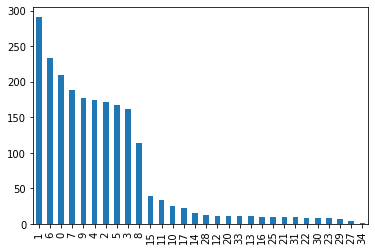

In [ ]:
import pandas as pd
train_data_dir = os.path.join(ROOT_PATH)
# Doc du lieu
X, y = load_data(train_data_dir)
print("Read data done")
df = pd.DataFrame({
    'train_label': y,
})
df['train_label'].value_counts().plot.bar()
print(df['train_label'].value_counts())


# Chia dữ liệu

**Chia tập dữ liệu 80% cho training 20% cho test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("split data done")

split data done


# Training

**Chọn training SVM**

In [ ]:
svmFlag=True
if svmFlag is True:
  model = linear_svm(X_train, y_train,X_test,y_test)
  # Luu trong so da huan luyen
  save_model(model, "svm", PATH_WEIGHT)

[!] SVM data...
score 0.9421296296296297
[+] Finished
[+] Saving model to file :  svm.joblib


**Chọn training KNN**

In [ ]:
knnFlag=True
if knnFlag is True:
  model=KNN(X_train, y_train,X_test,y_test)
  save_model(model, "knn", PATH_WEIGHT)

[!] KNN data...
2   0.8935185185185185
3   0.9004629629629629
4   0.8935185185185185
5   0.8888888888888888
6   0.8888888888888888
7   0.8865740740740741
8   0.8773148148148148
9   0.875
10   0.8587962962962963
11   0.8634259259259259
12   0.8541666666666666
13   0.8611111111111112
14   0.8518518518518519
15   0.8425925925925926
16   0.8425925925925926
17   0.8356481481481481
18   0.8333333333333334
19   0.8287037037037037
20   0.8333333333333334
21   0.8287037037037037
22   0.8287037037037037
23   0.8263888888888888
24   0.8263888888888888
25   0.8263888888888888
Best K is :3
score 0.9004629629629629
[+] Finished
[+] Saving model to file :  knn.joblib
